In [40]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt





[*********************100%***********************]  2 of 2 completed
/var/folders/j7/k4yx4mcn55l6gwhdd1p1k4ym0000gn/T/ipykernel_5766/212946955.py:24: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rebalance_dates = log_rets.resample(rebalance_freq).first().index


Training Sharpe Ratio: 0.0787
Validation Sharpe Ratio: 0.7829


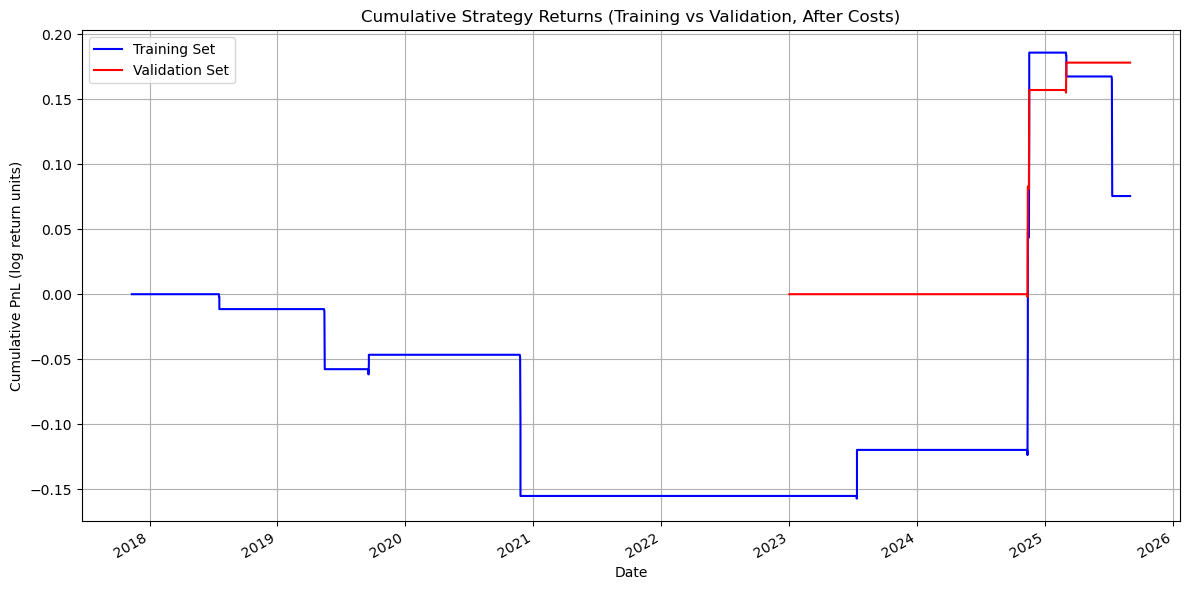

In [50]:
# Parameters
tickers = ['ADA-USD', 'XLM-USD']
start_date = "2016-01-01"
split_date = "2023-01-01"
rebalance_freq = "Q"       
lookback_days = 180        
zscore_lookback = 30       
tcost = 0.002              

# Entry/Exit Thresholds
entry_threshold = 4.0
exit_threshold = 3.0


# Get data
prices = yf.download(tickers, start=start_date)['Close']
log_rets = np.log(prices / prices.shift(1)).dropna()

# Split data
train = log_rets[log_rets.index < split_date]
val = log_rets[log_rets.index >= split_date]

# Prep rebalance dates
rebalance_dates = log_rets.resample(rebalance_freq).first().index

# Storage
train_returns = []
val_returns = []

alphas = []
betas = []

# Main loop 
for i in range(1, len(rebalance_dates)):

    train_end = rebalance_dates[i]
    train_start = train_end - pd.Timedelta(days=lookback_days)
    train_window = log_rets[(log_rets.index >= train_start) & (log_rets.index < train_end)]

    if len(train_window) < lookback_days // 2:
        continue

    # Fit OLS regression (XLM on ADA)
    X_train = sm.add_constant(train_window['ADA-USD'])
    Y_train = train_window['XLM-USD']
    model = sm.OLS(Y_train, X_train).fit()
    alpha, beta = model.params
    alphas.append(alpha)
    betas.append(beta)

    # Spread (price residual)
    spread_train = train_window['XLM-USD'] - (alpha + beta * train_window['ADA-USD'])

    # Rolling z-score
    zscore_train = (spread_train - spread_train.rolling(zscore_lookback).mean()) / spread_train.rolling(zscore_lookback).std()

    # Generate trading signals
    signals_train = pd.Series(0, index=zscore_train.index)
    signals_train[zscore_train > entry_threshold] = -1   # Short spread
    signals_train[zscore_train < -entry_threshold] = 1   # Long spread
    signals_train[zscore_train.abs() < exit_threshold] = 0
    signals_train = signals_train.ffill().fillna(0)

    # Strategy returns = weighted log returns
    strat_train = signals_train.shift(1) * (train_window['XLM-USD'] - beta * train_window['ADA-USD'])

    # Transaction costs
    trades = signals_train.diff().abs()
    strat_train -= trades * tcost
    train_returns.append(strat_train.dropna())

    # Validation window
    val_start = train_end
    val_end = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else val.index[-1]
    val_window = val[(val.index >= val_start) & (val.index < val_end)]

    if len(val_window) == 0:
        continue

    spread_val = val_window['XLM-USD'] - (alpha + beta * val_window['ADA-USD'])
    zscore_val = (spread_val - spread_val.rolling(zscore_lookback).mean()) / spread_val.rolling(zscore_lookback).std()

    signals_val = pd.Series(0, index=zscore_val.index)
    signals_val[zscore_val > entry_threshold] = -1
    signals_val[zscore_val < -entry_threshold] = 1
    signals_val[zscore_val.abs() < exit_threshold] = 0
    signals_val = signals_val.ffill().fillna(0)

    strat_val = signals_val.shift(1) * (val_window['XLM-USD'] - beta * val_window['ADA-USD'])

    trades_val = signals_val.diff().abs()
    strat_val -= trades_val * tcost
    val_returns.append(strat_val.dropna())

# Finalize findings
train_strategy_returns = pd.concat(train_returns).sort_index()
val_strategy_returns = pd.concat(val_returns).sort_index()

# Sharpe
def sharpe(series):
    return (series.mean() / series.std()) * np.sqrt(252) if series.std() != 0 else 0

sharpe_train = sharpe(train_strategy_returns)
sharpe_val = sharpe(val_strategy_returns)

print(f"Training Sharpe Ratio: {sharpe_train:.4f}")
print(f"Validation Sharpe Ratio: {sharpe_val:.4f}")

# Graph
plt.figure(figsize=(12, 6))
train_strategy_returns.cumsum().plot(label='Training Set', color='blue')
val_strategy_returns.cumsum().plot(label='Validation Set', color='red')
plt.title("Cumulative Strategy Returns (Training vs Validation, After Costs)")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL (log return units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  26 of 26 completed


Portfolio Training Sharpe Ratio: 0.5401
Portfolio Validation Sharpe Ratio: 0.5267


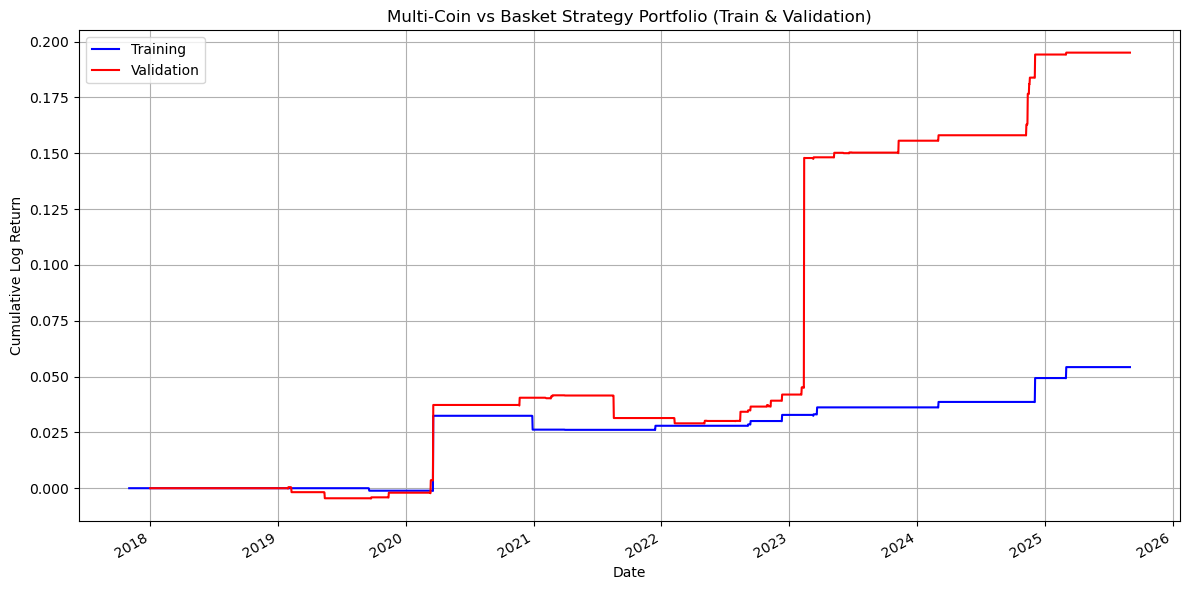

In [52]:


# Coins
top_25 = [
    'BTC-USD', 'ETH-USD', 'USDT-USD', 'XRP-USD', 'BNB-USD', 'USDC-USD', 'SOL-USD',
    'DOGE-USD', 'TRX-USD', 'ADA-USD', 'STETH-USD', 'WBTC-USD', 'LEO-USD',
    'LINK-USD', 'USDS-USD', 'AVAX-USD', 'TON-USD', 'HBAR-USD', 'XLM-USD',
    'SUI-USD', 'SHIB-USD', 'WSTETH-USD', 'OM-USD', 'BCH-USD', 'LTC-USD', 'DOT-USD'
]

start_date = "2016-01-01"
split_date = "2023-01-01"
rebalance_freq = "QE"  # quarterly end
lookback_days = 60
zscore_lookback = 30
tcost = 0.002
entry_threshold = 4.5
exit_threshold = 0.5

# Get data
data = yf.download(top_25, start=start_date)['Close']
log_rets = np.log(data / data.shift(1))

# Rebalance dates
rebalance_dates = log_rets.resample(rebalance_freq).first().index

# Storage
train_returns_all = []
val_returns_all = []

# Main loop
for coin in top_25:
    # Skip coins with too little data
    coin_data = log_rets[coin].dropna()
    if len(coin_data) < lookback_days:
        continue

    train_returns = []
    val_returns = []

    for i in range(1, len(rebalance_dates)):
        train_end = rebalance_dates[i]
        train_start = train_end - pd.Timedelta(days=lookback_days)
        train_window = log_rets.loc[train_start:train_end]

        if coin not in train_window.columns or train_window[coin].dropna().empty:
            continue

        
        basket = [c for c in train_window.columns if c != coin and train_window[c].dropna().shape[0] > 0]
        if len(basket) < 2:
            continue

        # Regression
        basket_train = train_window[basket].mean(axis=1)
        basket_train.name = 'Basket'
        Y_train = train_window[coin]
        X_train = sm.add_constant(basket_train)
        model = sm.OLS(Y_train, X_train, missing='drop').fit()
        alpha = model.params['const']
        beta = model.params['Basket']

        # Signals/Rets (Training)
        spread_train = Y_train - (alpha + beta * basket_train)
        z_train = (spread_train - spread_train.rolling(zscore_lookback).mean()) / spread_train.rolling(zscore_lookback).std()
        signals_train = pd.Series(0, index=z_train.index)
        signals_train[z_train > entry_threshold] = -1
        signals_train[z_train < -entry_threshold] = 1
        signals_train[z_train.abs() < exit_threshold] = 0
        signals_train = signals_train.ffill().fillna(0)

        pnl_train = signals_train.shift(1) * (Y_train - beta * basket_train)
        trades_train = signals_train.diff().abs()
        pnl_train -= trades_train * tcost
        train_returns.append(pnl_train.dropna())

        # Signals/Rets (Validation)
        val_start = train_end
        val_end = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else log_rets.index[-1]
        val_window = log_rets.loc[val_start:val_end]

        if coin not in val_window.columns or val_window[coin].dropna().empty:
            continue

        
        basket_val = [c for c in basket if c in val_window.columns and val_window[c].dropna().shape[0] > 0]
        if len(basket_val) < 1:
            continue

        basket_val_series = val_window[basket_val].mean(axis=1)
        basket_val_series.name = 'Basket'

        spread_val = val_window[coin] - (alpha + beta * basket_val_series)
        z_val = (spread_val - spread_val.rolling(zscore_lookback).mean()) / spread_val.rolling(zscore_lookback).std()
        signals_val = pd.Series(0, index=z_val.index)
        signals_val[z_val > entry_threshold] = -1
        signals_val[z_val < -entry_threshold] = 1
        signals_val[z_val.abs() < exit_threshold] = 0
        signals_val = signals_val.ffill().fillna(0)

        pnl_val = signals_val.shift(1) * (val_window[coin] - beta * basket_val_series)
        trades_val = signals_val.diff().abs()
        pnl_val -= trades_val * tcost
        val_returns.append(pnl_val.dropna())

    if train_returns:
        train_returns_all.append(pd.concat(train_returns).sort_index())
    if val_returns:
        val_returns_all.append(pd.concat(val_returns).sort_index())

# Combine rets
combined_train = pd.concat(train_returns_all, axis=1).mean(axis=1)
combined_val = pd.concat(val_returns_all, axis=1).mean(axis=1)

# SR
def sharpe(series):
    return (series.mean() / series.std()) * np.sqrt(252) if series.std() != 0 else 0

sharpe_train = sharpe(combined_train)
sharpe_val = sharpe(combined_val)
print(f"Portfolio Training Sharpe Ratio: {sharpe_train:.4f}")
print(f"Portfolio Validation Sharpe Ratio: {sharpe_val:.4f}")

# Graph
plt.figure(figsize=(12, 6))
combined_train.cumsum().plot(label="Training", color='blue')
combined_val.cumsum().plot(label="Validation", color='red')
plt.title("Multi-Coin vs Basket Strategy Portfolio (Train & Validation)")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Combined Portfolio Training Sharpe Ratio: 0.3531
Combined Portfolio Validation Sharpe Ratio: 1.0225


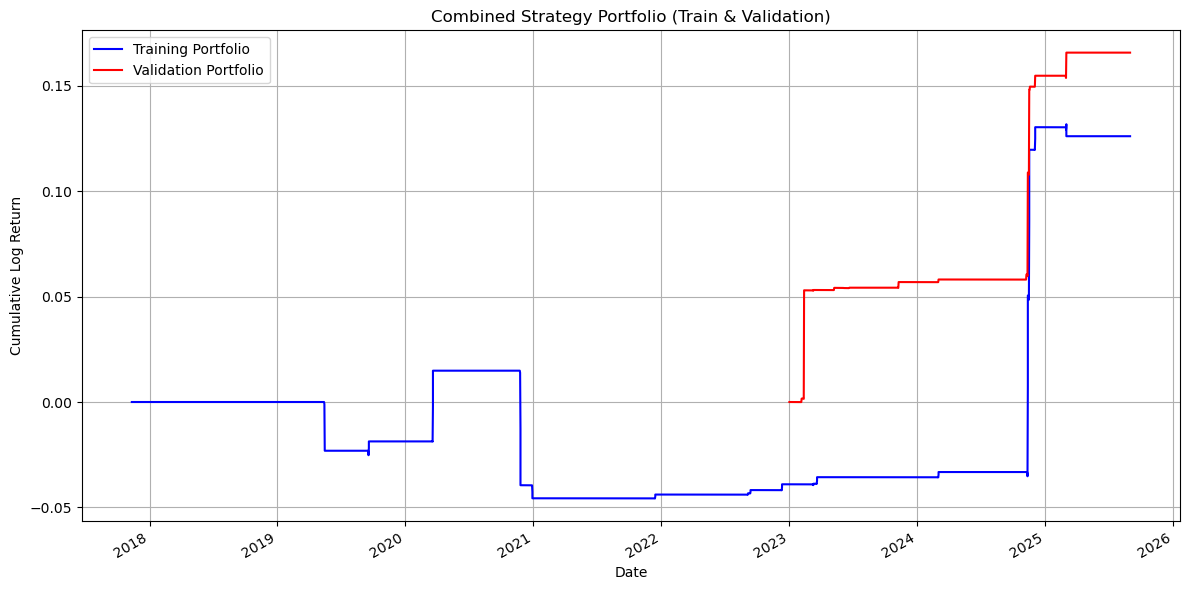

In [54]:
# Align strat rets
train_index = train_strategy_returns.index.intersection(combined_train.index)
val_index = val_strategy_returns.index.intersection(combined_val.index)

train_combined = pd.DataFrame({
    'ADA_XLM': train_strategy_returns.loc[train_index],
    'Basket': combined_train.loc[train_index]
})

val_combined = pd.DataFrame({
    'ADA_XLM': val_strategy_returns.loc[val_index],
    'Basket': combined_val.loc[val_index]
})

# Combine strats
# Equal weight
train_portfolio = train_combined.mean(axis=1)
val_portfolio = val_combined.mean(axis=1)

# SRs
def sharpe(series):
    return (series.mean() / series.std()) * np.sqrt(252) if series.std() != 0 else 0

sharpe_train_port = sharpe(train_portfolio)
sharpe_val_port = sharpe(val_portfolio)

print(f"Combined Portfolio Training Sharpe Ratio: {sharpe_train_port:.4f}")
print(f"Combined Portfolio Validation Sharpe Ratio: {sharpe_val_port:.4f}")

# Graph combined portfolio
plt.figure(figsize=(12, 6))
train_portfolio.cumsum().plot(label="Training Portfolio", color='blue')
val_portfolio.cumsum().plot(label="Validation Portfolio", color='red')
plt.title("Combined Strategy Portfolio (Train & Validation)")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:               Strategy   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02575
Date:                Mon, 01 Sep 2025   Prob (F-statistic):              0.873
Time:                        16:49:45   Log-Likelihood:                 9466.9
No. Observations:                1882   AIC:                        -1.893e+04
Df Residuals:                    1880   BIC:                        -1.892e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.082e-05   3.65e-05      0.845      0.3

<Figure size 2000x1000 with 0 Axes>

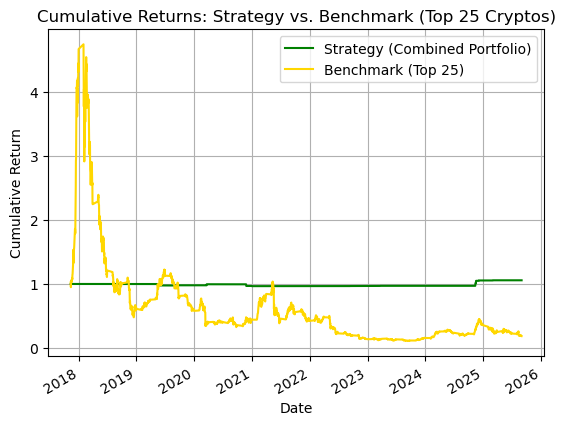

In [70]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


strategy_returns = train_portfolio  

# Remove duplicates
strategy_returns = strategy_returns.loc[~strategy_returns.index.duplicated()]
benchmark_returns = log_rets[top_25].mean(axis=1).loc[~log_rets[top_25].mean(axis=1).index.duplicated()]

# Align strat rets
combined = pd.concat([strategy_returns, benchmark_returns], axis=1).dropna()
combined.columns = ['Strategy', 'Benchmark']

# Run regression against benchmark
X = sm.add_constant(combined['Benchmark'])  # Add intercept for alpha
Y = combined['Strategy']

model = sm.OLS(Y, X).fit()
print(model.summary())

# Graph
plt.figure(figsize=(20, 10))
(1 + combined).cumprod().plot(color=['green', 'gold'])
plt.title("Cumulative Returns: Strategy vs. Benchmark (Top 25 Cryptos)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend(['Strategy (Combined Portfolio)', 'Benchmark (Top 25)'])
plt.show()





